In [1]:
import pandas as pd
import os
from scipy.sparse import csr_matrix
import numpy as np
import math

# Data reading + EDA

In [2]:
# path = os.getcwd() + r'/data/'
# aisles = pd.read_csv(path + r'/aisles.csv', index_col=0)
# departments = pd.read_csv(path + r'/departments.csv', index_col=0)
# products = pd.read_csv(path + r'/products.csv')
# orders = pd.read_csv(path + r'/orders.csv')
# order_product_prior = pd.read_csv(path + r'/order_products__prior.csv')
# order_product_train = pd.read_csv(path + r'/order_products__train.csv')

In [3]:
# """
# Data preparation, since feedback is implicit, we can use amount of times user bought the product,
# that's why we need to have a split before the rating evaluation.

# Split is taken by last order each user've done, since everyone had been done at least 3 orders

# """

# order_product = pd.concat([order_product_prior, order_product_train])
# products = products.merge(departments, on='department_id')
# products = products.merge(aisles, on='aisle_id')
# products.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
# orders = orders.set_index('order_id')
# order_product = order_product.merge(products, on='product_id')
# merged_data = order_product.merge(orders, on='order_id')
# merged_data = merged_data.drop(['add_to_cart_order', 'order_dow', 'days_since_prior_order', 'eval_set'], axis=1)

# data = merged_data
# last_orders = data.order_id.isin(
#             data.sort_values(by=['user_id', 'order_number']).groupby('user_id').tail(1)['order_id'])

# train_data=data[~last_orders]
# test_data=data[last_orders]



# ratings = train_data.groupby(['user_id', 'product_id']).count()['order_id']
# ratings.name = 'amount'
# train_data = train_data.merge(ratings, on=['user_id', 'product_id'])

In [5]:
# train_data.to_csv('train_data.csv')
# test_data.to_csv('test_data.csv')

In [2]:
import pandas as pd
import os
from scipy.sparse import csr_matrix

In [3]:
train_data = pd.read_csv('train_data.csv', index_col=0)
test_data = pd.read_csv('test_data.csv', index_col=0)

C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
test_data.order_id.nunique()

206209

## EDA

In [8]:
data[['product_id', 'user_id', 'order_id']].nunique()

product_id      49685
user_id        206209
order_id      3346083
dtype: int64

In [9]:
data.groupby('user_id')['order_id'].count().sort_values()[::-1]

user_id
201268    3725
129928    3689
164055    3089
176478    2952
186704    2936
          ... 
75435        3
93946        3
84062        3
142698       3
99295        3
Name: order_id, Length: 206209, dtype: int64

<AxesSubplot:>

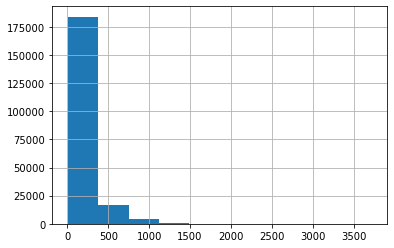

In [10]:
data.groupby('user_id')['order_id'].count().sort_values().hist()

In [11]:
data.groupby('product_id')['order_id'].count().sort_values()

product_id
36233         1
11254         1
43098         1
14485         1
7626          1
          ...  
47209    220877
21903    251705
21137    275577
13176    394930
24852    491291
Name: order_id, Length: 49685, dtype: int64

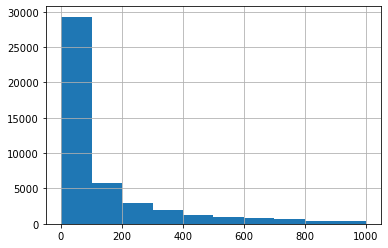

In [12]:
tmp = data.groupby('product_id')['order_id'].count().sort_values()
tmp[tmp < 1000].hist()
del tmp

Существуют выбросы в большую сторону, например, самые популярные продукты, как бананы. Большинство товаров заказано меньше 100 раз

Минимум 3 заказа на пользователя

Минимум 1 заказ на продукт


# Метрики (из первого задания)

In [5]:
def hitrate(y_true, y_pred, k):
    return np.mean([len([x for x in y_pred[i][:k] if x in y_true[i]]) > 0 for i in range(len(y_pred))])

In [6]:
def p(y_true, y_pred, k):
    return len([x for x in y_pred[:k] if x in y_true])/k
def ap(y_true, y_pred, k):
    if k > len(y_pred):
        raise(ValueError)
    if k == 0:
        return 0
    tmp = np.sum([int(y_pred[i] in y_true) for i in range(k)])
    if tmp == 0:
        return 0
    return sum([(y_pred[i] in y_true) * p(y_true, y_pred, i+1) for i in range(k)]) / tmp
def map_k(y_true, y_pred, k):
    return np.mean([ap(y_true[i], y_pred[i], k) for i in range(len(y_true))])

In [7]:
def dcg(ratings, k):
    if k > len(ratings):
        raise ValueError
    return np.sum([(2**ratings[i] - 1) / math.log2(i+2) for i in range(k)])
def idcg(k):
    return np.sum([1 / math.log2(i+2) for i in range(k)])
def ndcg(ratings, k):
    if k > len(ratings):
        raise ValueError
    return dcg(ratings, k) / idcg(k)
def mean_ndcg(results, k):
    return np.mean([ndcg(i, k) for i in results])

def evaluate_ndcg(data, k):
    return data.groupby('user_id')['amount'].apply(list).apply(lambda x: ndcg(x, 10)).mean()

In [8]:
"""Calculate all the metrics at once"""

def metrics(test, result, k=10):
    res = result.sort_values(by=['user_id', 'item_order'])
    res = res.drop_duplicates(['user_id', 'product_id'])
    test = test.sort_values(by='user_id')
    y_true = list(test.groupby('user_id')['product_id'].apply(list))
    preds = list(res.groupby('user_id')['product_id'].apply(list))
    print('Hitrate@{} '.format(k), round(hitrate(y_true, preds, k), 3))
    print('MAP@{} '.format(k), round(map_k(y_true, preds, k), 3))

## CF

In [9]:
train_data = train_data[['user_id', 'product_id', 'order_id', 'amount', 'order_number']]
test_data = test_data[['user_id', 'product_id', 'order_id']]

In [10]:
train_data

,user_id,product_id,order_id,amount,order_number
0,202279,33120,2,5,3
1,202279,33120,104690,5,8
2,202279,33120,132412,5,6
3,202279,33120,2808715,5,5
4,202279,33120,2894949,5,1
...,...,...,...,...,...
31653684,117521,13189,2858225,1,3
31653685,189140,47680,1666202,1,2
31653686,182854,34390,1699504,1,10
31653687,51836,31530,2666238,1,12


Creating maps to encode users/items in scipy sparse matrix to avoid memory issues in further processing

In [11]:
user_map = {v: i for i,v in enumerate(sorted(train_data['user_id'].unique()))}

In [12]:
item_map = {v: i for i,v in enumerate(sorted(train_data['product_id'].unique()))}

In [13]:
"""Creates CF matrix based on the amount of buys per product, drop duplicates to avoid squaring the rating"""

CF  = csr_matrix((train_data.amount, 
                  (train_data.user_id.apply(lambda x: user_map[x]),
                   train_data.product_id.apply(lambda x: item_map[x]))))

In [14]:
CF.shape

(206209, 49668)

# Recommenders

## Most popular

In [24]:
MP = train_data.groupby('product_id').count().sort_values(by='user_id', ascending=False)[:20].index

In [25]:
MP

Int64Index([24852, 13176, 21137, 21903, 47209, 47766, 47626, 16797, 26209,
            27845, 27966, 22935, 24964, 45007, 39275, 49683, 28204,  5876,
             8277, 40706],
           dtype='int64', name='product_id')

In [26]:
k = 10
result = pd.DataFrame({
            'user_id': np.repeat(test_data.user_id.unique(), k),
            'product_id': list(MP[:k]) * test_data.user_id.unique().shape[0],
            'item_order': list(range(1, k + 1)) * test_data.user_id.unique().shape[0]
        })

In [140]:
MP_res = result

In [141]:
"""Merge result on train to get the rating of the predicted products"""

MP_res = MP_res.merge(train_data.drop_duplicates(['user_id', 'product_id']), on=['user_id', 'product_id'], how='left')[['user_id', 'product_id', 'item_order', 'amount']]

In [142]:
MP_res

,user_id,product_id,item_order,amount
0,116952,24852,1,6.0
1,116952,13176,2,NaN
2,116952,21137,3,6.0
3,116952,21903,4,NaN
4,116952,47209,5,NaN
...,...,...,...,...
2062085,184060,47766,6,NaN
2062086,184060,47626,7,NaN
2062087,184060,16797,8,NaN
2062088,184060,26209,9,NaN


In [143]:
MP_res['amount'][MP_res.amount.isna()] = 0

In [144]:
# %%time
# metrics(test_data, MP_res)

In [145]:
MP_res.amount = MP_res.amount / max(MP_res.amount) * 3

In [146]:
MP_res.groupby('user_id')['amount'].apply(list).apply(lambda x: ndcg(x, 10)).mean()

0.03419433657726226

#### Results of MP (just to safe and don't rerun code)
- Hitrate@10  0.457
- MAP@10  0.22
- nDCG@10 0.034

## SVD recommender

In [151]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [152]:
"""Uses SVD decompositions to create user/items embeddings to recreate matrix afterwards"""

svd = TruncatedSVD(n_components=100, random_state=42)

u = svd.fit_transform(CF) / svd.singular_values_
s = np.diag(svd.singular_values_)
vt = svd.components_

In [153]:
u.shape

(206209, 100)

In [154]:
"""Batch processing to avoid memory issues"""

def batch(obj, n):
    lenght = len(obj)
    for i in range(0, lenght, n):
        yield obj[i:min(i + n, lenght)]

In [155]:
from tqdm import tqdm

In [156]:

"""Recreates matrix by batches, sort values, gets recommendations for each user. Type int32 to reduce memory usage,
since ratings are 

"""
k = 10
top_matrix_ind = []
for b in tqdm(batch(u, 50)):
    top_matrix_ind += list(
                map(lambda x: np.array(x[:k], dtype='int32'),
                    np.argsort(-np.dot(np.dot(b, s), vt))))

4125it [21:20,  3.22it/s]


In [158]:
"""Decode recommendations from CF maps"""

rev_item_map = {v: k for k, v in item_map.items()}
svd_res = np.array([list(map(lambda x: rev_item_map[x], arr)) for arr in top_matrix_ind])


In [159]:
svd_res = [svd_res[i] for i in test_data.user_id.apply(lambda x: user_map[x]).unique()]

In [160]:
SVD_res = pd.DataFrame(np.repeat(test_data.user_id.unique(), 10))

In [162]:
SVD_res['product_id'] = np.array(svd_res).flatten()

In [163]:
SVD_res.columns = ['user_id', 'product_id']

In [164]:
SVD_res['item_order'] = list(range(1, 11)) * test_data.user_id.nunique()

In [165]:
SVD_res

,user_id,product_id,item_order
0,116952,39877,1
1,116952,24852,2
2,116952,21137,3
3,116952,9839,4
4,116952,25931,5
...,...,...,...
2062085,184060,20119,6
2062086,184060,26620,7
2062087,184060,46676,8
2062088,184060,49044,9


In [167]:
SVD_res = SVD_res.merge(train_data.drop_duplicates(['user_id', 'product_id']), on=['user_id', 'product_id'], how='left')[['user_id', 'product_id', 'item_order', 'amount']]

In [168]:
SVD_res['amount'][SVD_res.amount.isna()] = 0

In [169]:
SVD_res.amount = SVD_res.amount / max(SVD_res.amount) * 3

In [166]:
v

Hitrate@10  0.64
MAP@10  0.428


In [170]:
SVD_res.groupby('user_id')['amount'].apply(list).apply(lambda x: ndcg(x, 10)).mean()

0.09147729585856695

- Hitrate@10  0.64
- MAP@10  0.428
- nDCG@10 0.091

## NN recommender

In [17]:
nn_train = train_data[['user_id', 'product_id']].drop_duplicates()

In [18]:
nn_train['rating'] = 1

In [19]:
nn_test = test_data[['user_id', 'product_id']].drop_duplicates()

In [20]:
uids = np.array(nn_train.user_id.apply(lambda x: user_map[x]))
iids = np.array(nn_train.product_id.apply(lambda x: item_map[x]))

In [21]:
users = nn_train.user_id.apply(lambda x: user_map[x]).unique()
items = nn_train.product_id.apply(lambda x: item_map[x]).unique()

In [26]:
zipped = set(zip(uids, iids))
def train_samples():
    user_input, item_input, labels = [],[],[]
    for (u, i) in zip(uids,iids):
    # Add our positive interaction
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        for t in range(5):
            j = np.random.randint(len(items))
            while (u, j) in zipped:
                j = np.random.randint(len(items))
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

In [37]:
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import math
import heapq
from tqdm import tqdm
from numpy.random import shuffle


num_neg = 4
epochs = 20
batch_size = 256
learning_rate = 0.001


graph = tf.Graph()

with graph.as_default():

    """The model creates embeddings for users/items concat them & runs it with the dense layers to binary classification"""
    
    user = tf.placeholder(tf.int32, shape=(None, 1))
    item = tf.placeholder(tf.int32, shape=(None, 1))
    label = tf.placeholder(tf.int32, shape=(None, 1))

    # User feature embedding
    u_var = tf.Variable(tf.random_normal([len(users), 32], stddev=0.05), name='user_embedding')
    user_embedding = tf.nn.embedding_lookup(u_var, user)

    # Item feature embedding
    i_var = tf.Variable(tf.random_normal([len(items), 32], stddev=0.05), name='item_embedding')
    item_embedding = tf.nn.embedding_lookup(i_var, item)

    user_embedding = tf.keras.layers.Flatten()(user_embedding)
    item_embedding = tf.keras.layers.Flatten()(item_embedding)

    concatenated = tf.keras.layers.concatenate([user_embedding, item_embedding])

    dropout = tf.keras.layers.Dropout(0.2)(concatenated)


    layer_1 = tf.keras.layers.Dense(64, activation='relu', name='layer1')(dropout)
    batch_norm1 = tf.keras.layers.BatchNormalization(name='batch_norm1')(layer_1)
    dropout1 = tf.keras.layers.Dropout(0.2, name='dropout1')(batch_norm1)

    layer_2 = tf.keras.layers.Dense(32, activation='relu', name='layer2')(layer_1)
    batch_norm2 = tf.keras.layers.BatchNormalization(name='batch_norm1')(layer_2)
    dropout2 = tf.keras.layers.Dropout(0.2, name='dropout1')(batch_norm2)

    layer_3 = tf.keras.layers.Dense(16, activation='relu', name='layer3')(layer_2)
    layer_4 = tf.keras.layers.Dense(8, activation='relu', name='layer4')(layer_3)

    output_layer = tf.keras.layers.Dense(1,
            kernel_initializer="lecun_uniform",
            name='output_layer')(layer_4)

    labels = tf.cast(label, tf.float32)
    logits = output_layer
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=labels,
                logits=logits))
.
    opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
    step = opt.minimize(loss)

    init = tf.global_variables_initializer()

session = tf.Session(config=None, graph=graph)
session.run(init)

In [45]:
def random_mini_batches(U, I, L, mini_batch_size=256):
    """Creates batches for the NN rec
    """

    mini_batches = []
    s = pd.DataFrame({'U':U, 'I':I, "L":L})
    shuffled_U, shuffled_I, shuffled_L = list(s['U']), list(s['I']), list(s['L'])

    num_complete_batches = int(math.floor(len(U)/mini_batch_size))
    for k in range(0, num_complete_batches):
        mini_batch_U = shuffled_U[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_I = shuffled_I[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_L = shuffled_L[k * mini_batch_size : k * mini_batch_size + mini_batch_size]

        mini_batch = (mini_batch_U, mini_batch_I, mini_batch_L)
        mini_batches.append(mini_batch)

    if len(U) % mini_batch_size != 0:
        mini_batch_U = shuffled_U[num_complete_batches * mini_batch_size: len(U)]
        mini_batch_I = shuffled_I[num_complete_batches * mini_batch_size: len(U)]
        mini_batch_L = shuffled_L[num_complete_batches * mini_batch_size: len(U)]

        mini_batch = (mini_batch_U, mini_batch_I, mini_batch_L)
        mini_batches.append(mini_batch)

    return mini_batches



In [ ]:
for epoch in range(epochs):

    """Get our training input.
    Loop over each batch and feed our users, items and labels into the graph. """
    user_input, item_input, labels = train_samples()


    minibatches = random_mini_batches(user_input, item_input, labels)


    for minibatch in minibatches:
        feed_dict = {user: np.array(minibatch[0]).reshape(-1,1),
                    item: np.array(minibatch[1]).reshape(-1,1),
                    label: np.array(minibatch[2]).reshape(-1,1)}
        _, l = session.run([step, loss], feed_dict)


    progress.close()

## ALS recommender

In [89]:
import implicit

In [124]:
train_data

,user_id,product_id,order_id,amount,order_number
0,202279,33120,2,5,3
1,202279,33120,104690,5,8
2,202279,33120,132412,5,6
3,202279,33120,2808715,5,5
4,202279,33120,2894949,5,1
...,...,...,...,...,...
31653684,117521,13189,2858225,1,3
31653685,189140,47680,1666202,1,2
31653686,182854,34390,1699504,1,10
31653687,51836,31530,2666238,1,12


In [90]:
model = implicit.als.AlternatingLeastSquares(factors=50, random_state=42)

In [125]:
"""Fits transpose CF matrix to lib recommender"""
model.fit(CF.T.tocsr())

In [128]:
t = pd.Series(CF1[0].toarray()[0])

In [129]:
t[t != 0]

195      100
10253     81
10321      1
12421    100
13026      9
13170      4
14078      1
17116      1
25127     64
26081      4
26398      4
30439      1
35940      1
38913      1
39641      1
41771      1
46130      9
49215      4
dtype: int64

In [33]:
rev_item_map = {v: k for k, v in item_map.items()}

In [130]:
"""gets recs for each user from lib model"""

recs = []
for user in tqdm(test_data.user_id.unique()):
    ids = user_map[user]
    user_recs = model.recommend(ids, CF, N=10, filter_already_liked_items=False)
    user_recs = [rev_item_map[i[0]] for i in user_recs]
    recs.append(user_recs)

100%|█████████████████████████████████████████████████████████████████████████| 206209/206209 [03:33<00:00, 966.89it/s]


In [131]:
ALS_res = pd.DataFrame({
            'user_id': np.repeat(test_data.user_id.unique(), 10),
            'product_id': np.array(recs).flatten(),
            'item_order': list(range(1, 11)) * test_data.user_id.unique().shape[0]
        })

In [132]:
ALS_res

,user_id,product_id,item_order
0,116952,24852,1
1,116952,21137,2
2,116952,39877,3
3,116952,30391,4
4,116952,39275,5
...,...,...,...
2062085,184060,19348,6
2062086,184060,20119,7
2062087,184060,46979,8
2062088,184060,28204,9


In [133]:
test_data

,user_id,product_id,order_id
343,116952,33120,3302
344,116952,21137,3302
345,116952,49235,3302
346,116952,5077,3302
347,116952,25230,3302
...,...,...,...
33819051,204952,973,567548
33819083,102127,19833,607607
33819091,9798,43134,2570526
33819101,170084,28717,2839453


In [135]:
ALS_res = ALS_res.merge(train_data.drop_duplicates(['user_id', 'product_id']), on=['user_id', 'product_id'], how='left')[['user_id', 'product_id', 'item_order', 'amount']]

In [136]:
ALS_res['amount'][ALS_res.amount.isna()] = 0

metrics(test_data, ALS_res)

In [138]:
ALS_res.amount = ALS_res.amount / max(ALS_res.amount) * 3

In [139]:
ALS_res.groupby('user_id')['amount'].apply(list).apply(lambda x: ndcg(x, 10)).mean()

0.06043338214892533

- Hitrate@10  0.671
- MAP@10  0.353
- nDCG 0.060

## KNN on SVD embeddings

In [16]:
"""Uses svd embeddings of items to create neighbourhood (Recommender is  item-based)"""

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, random_state=42)

svd_matrix = pd.DataFrame(svd.fit_transform(CF.transpose()))

In [18]:
from annoy import AnnoyIndex
from tqdm import tqdm

In [19]:
t = AnnoyIndex(1000, 'angular')

In [20]:
"""Creates items' neighbourhood"""
for i in tqdm(train_data.product_id.unique()):
    t.add_item(i, svd_matrix.loc[item_map[i]])

100%|██████████████████████████████████████████████████████████████████████████| 49668/49668 [00:21<00:00, 2313.16it/s]


In [21]:
t.build(10)

True

In [22]:
"""Gets the mean embedding of the products that user has ever bought"""
svd_matrix.loc[test_data[test_data.user_id == i].product_id.apply(lambda x: item_map[x]).unique()].mean(axis=0)

0     3351.495121
1     6973.871419
2    -1036.179614
3    -1404.534217
4     -213.842175
         ...     
95     -21.895512
96      41.767672
97     134.288380
98      26.092900
99     -84.206489
Length: 100, dtype: float64

In [23]:
"""Creates embedding for each user uses Annoy model to get recommendations of closest product to mean emb."""

KNN_res = pd.DataFrame(columns=['user_id', 'product_id', 'item_order'])
for i in tqdm(test_data.user_id.unique()):
    v = svd_matrix.loc[train_data[train_data.user_id == i].product_id.apply(lambda x: item_map[x]).unique()].mean(axis=0)
    KNN_res = KNN_res.append(pd.DataFrame({
            'user_id': np.repeat(i, 10),
            'product_id': t.get_nns_by_vector(v, 10),
            'item_order': list(range(1, 11))
        }))

100%|████████████████████████████████████████████████████████████████████████| 206209/206209 [5:25:17<00:00, 10.57it/s]


In [26]:
metrics(test_data, KNN_res)

In [27]:
KNN_res = KNN_res.merge(train_data.drop_duplicates(['user_id', 'product_id']), on=['user_id', 'product_id'], how='left')[['user_id', 'product_id', 'item_order', 'amount']]

In [28]:
KNN_res['amount'][KNN_res.amount.isna()] = 0

In [29]:
KNN_res.amount = KNN_res.amount / max(KNN_res.amount) * 3

In [36]:
KNN_res.groupby('user_id')['amount'].apply(list).apply(lambda x: ndcg(x, 10)).mean()

- HitRate@10     0.545
- MAP@10         0.305
- nDCG@10        0.041